# Day 03: Performing Regression with `scikit-learn` - solution

*This is only one of the possible solutions. There are many to answer the questions.*

![Regression Modeling](https://cdn-images-1.medium.com/v2/resize:fit:640/1*eeIvlwkMNG1wSmj3FR6M2g.gif)

## Learning goals

Today, we will make sure that every learns how they can use `scikit-learn` to perform regression analysis. We will also learn how to evaluate the performance of our regression models. In doing so, we will discuss how to interpret the results of our regression models and how different regression models can be compared.

After working through these ideas, you should be able to:
1. Use `scikit-learn` to perform regression analysis (i.e., linear regression).
2. Evaluate the performance of regression models.
3. Interpret the results of regression models.
4. Compare different regression models.
5. Explain how a linear regression model works.
6. Research how other regression models work and how they are implemented in `scikit-learn`.

## Notebook Instructions

We will work through the notebook making sure to write all necessary code and answer any questions. We will start together with the most commonly performed tasks. Then you will work on the analyses, posed as research questions, in groups.

## Outline

1. [Stellar Classification Dataset - SDSS17](#dataset)
2. [Modeling the z-band magnitude without redshift](#modeling-z-band-magnitude)
3. [Modeling the z-band magnitude with redshift](#modeling-z-band-magnitude-redshift)
4. [Modeling each class separately with redshift](#modeling-z-band-magnitude-class-redshift)
5. [Using other regression models (e.g., `RandomForestRegressor`)](#using-other-regression-models-e-g-randomforestregressor)

---
<a id="dataset"></a>
## 1. Stellar Classification Dataset - SDSS17

We will continue to work with the [Stellar Classification Dataset](https://www.kaggle.com/datasets/sswaroopkumar/stellar-classification-sdss17) from the Sloan Digital Sky Survey (SDSS). This dataset contains information about various astronomical objects, including their magnitudes in different bands, redshift values, and object classes. We will import the data set here and clean it up as we have noticed that there are some missing values in the dataset. 

We plot the data to confirm it's the same as before. 

### Import necessary libraries

#### ✅ Tasks:
1. Run the code below to import the necessary libraries and load the dataset.
2. Make sure you understand what each line of code does.

In [1]:
# necessary imports for this notebook
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks') # setting style
sns.set_context('talk') # setting context
sns.set_palette('colorblind') # setting palette

### Read the data and filter it

We again read the data in from a CSV file and filter it to remove any rows with missing values using `pandas`. We use `describe()` to get an overview of the dataset and check that we removed the missing values. 

In [2]:
stellar = pd.read_csv('https://raw.githubusercontent.com/dannycab/MSU_REU_ML_course/refs/heads/main/activities/data/star_classification.csv')
stellar.head()

# remove all the columns that are not needed
df_stellar = stellar[['obj_ID', 'class', 'u', 'g', 'r', 'i', 'z','redshift']]

# drop any row with negative photometric values
filter = (df_stellar['u'] >= 0) & (df_stellar['g'] >= 0) & (df_stellar['r'] >= 0) & (df_stellar['i'] >= 0) & (df_stellar['z'] >= 0)
df_stellar = df_stellar[filter]

# describe the data again
df_stellar.describe()

,obj_ID,u,g,r,i,z,redshift
count,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,1.237665e+18,22.080679,20.631583,19.645777,19.084865,18.768988,0.576667
std,8.438450e+12,2.251068,2.037384,1.854763,1.757900,1.765982,0.730709
min,1.237646e+18,10.996230,10.498200,9.822070,9.469903,9.612333,-0.009971
25%,1.237659e+18,20.352410,18.965240,18.135795,17.732280,17.460830,0.054522
50%,1.237663e+18,22.179140,21.099930,20.125310,19.405150,19.004600,0.424176
75%,1.237668e+18,23.687480,22.123775,21.044790,20.396510,19.921120,0.704172
max,1.237681e+18,32.781390,31.602240,29.571860,32.141470,29.383740,7.011245


### Plot the data to review it

This code is also from the [Exploring data with `pandas` notebook](./01-exploring-data-with-pandas.ipynb). We use `seaborn` to visualize the data. This just reminds us of the data we are working with and helps us understand the distribution of the features.

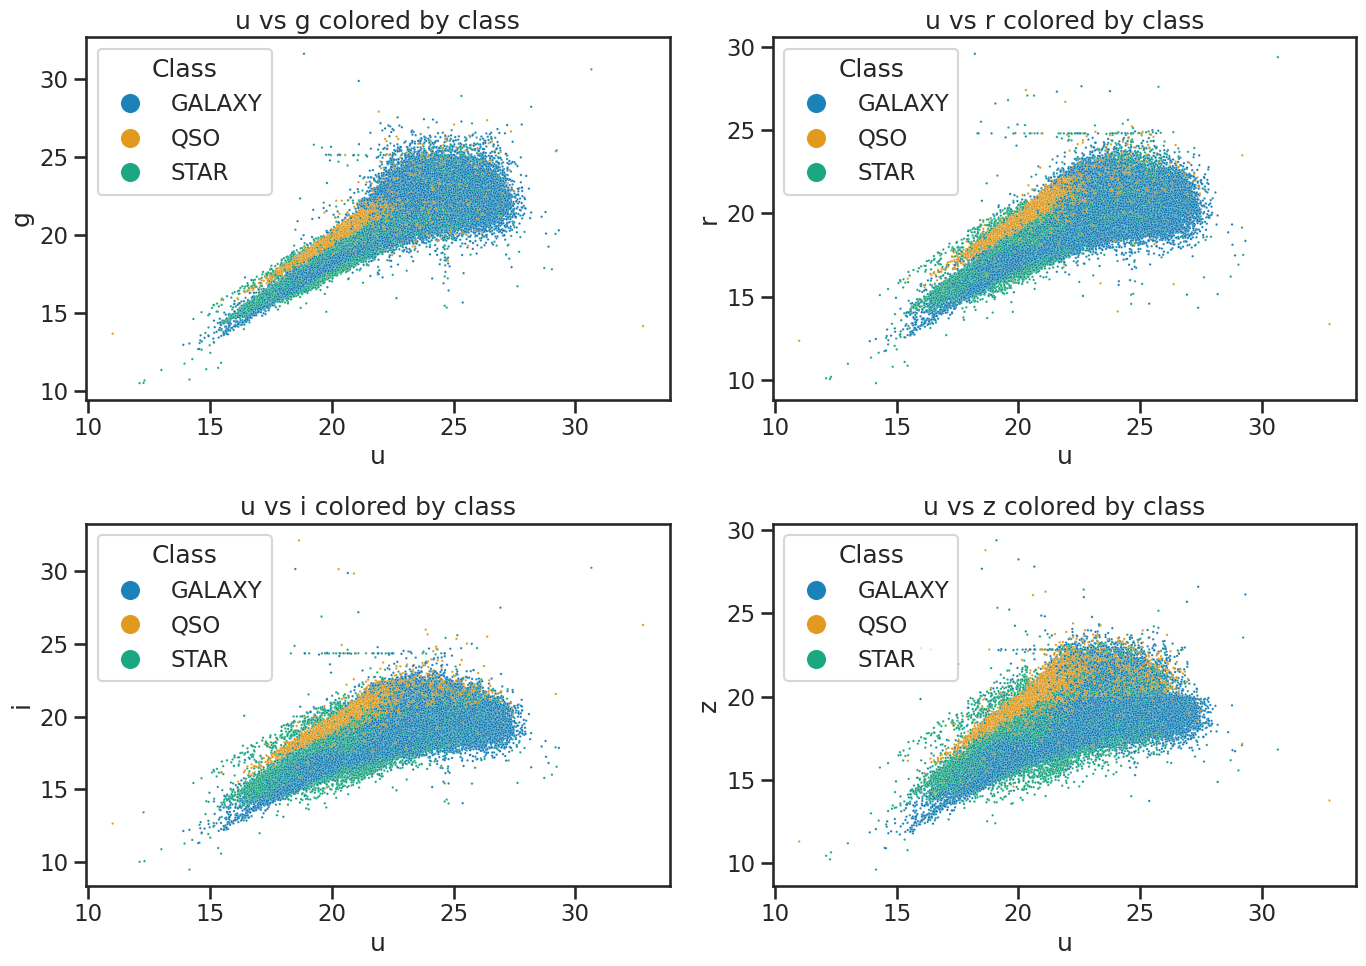

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# u vs g
sns.scatterplot(x='u', y='g', hue='class', data=df_stellar, ax=axes[0, 0], alpha=0.9, s=3)
axes[0, 0].set_xlabel('u')
axes[0, 0].set_ylabel('g')
axes[0, 0].set_title('u vs g colored by class')
axes[0, 0].legend(title='Class', loc='upper left', markerscale=8)

# u vs r
sns.scatterplot(x='u', y='r', hue='class', data=df_stellar, ax=axes[0, 1], alpha=0.9, s=3)
axes[0, 1].set_xlabel('u')
axes[0, 1].set_ylabel('r')
axes[0, 1].set_title('u vs r colored by class')
axes[0, 1].legend(title='Class', loc='upper left', markerscale=8)

# u vs i
sns.scatterplot(x='u', y='i', hue='class', data=df_stellar, ax=axes[1, 0], alpha=0.9, s=3)
axes[1, 0].set_xlabel('u')
axes[1, 0].set_ylabel('i')
axes[1, 0].set_title('u vs i colored by class')
axes[1, 0].legend(title='Class', loc='upper left', markerscale=8)

# u vs z
sns.scatterplot(x='u', y='z', hue='class', data=df_stellar, ax=axes[1, 1], alpha=0.9, s=3)
axes[1, 1].set_xlabel('u')
axes[1, 1].set_ylabel('z')
axes[1, 1].set_title('u vs z colored by class')
axes[1, 1].legend(title='Class', loc='upper left', markerscale=8)

plt.tight_layout()
plt.savefig('figures/stellar_color_diagrams.png', dpi=300)
plt.show()

---
<a id="modeling-z-band-magnitude"></a>
## 2. Modeling the z-band magnitude without redshift

We are going to perform a [linear regression](https://en.wikipedia.org/wiki/Linear_regression) on this dataset to predict the z-band magnitude of the objects based on various features. In doing so, we will explore the workflow of regression modeling with `scikit-learn`. You should know your data set well enough to know which features to use for the regression and to know if there are issues with the data that need to be addressed before we can perform the regression. Here, we are assuming these reasonable data that were collected and cleaned to be used for regression analysis.

### Import the necessary libraries and modules

We will be using the `model_selection`, `linear_model`, and `metrics` modules from `scikit-learn` to perform the regression analysis. Here we are going to import particular classes from these modules that are used for our analysis. You have seen `train_test_split` before, but we will also use `LinearRegression` to perform the regression analysis and `mean_squared_error` as well as `r2_score` to evaluate the performance of our regression model. When we start to evaluate the model we will also use some visualizations with `matplotlib` and `seaborn` to help us understand the results better.

#### ✅ Tasks:
1. Run the code below to perform a linear regression on the z-band magnitude without using redshift (pause when you get to the evaluation).
2. Make sure you understand what each line of code does.
3. Discuss any observations you have about the results of the regression model with your group.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Define the features and target variable

Below, we extract the features we are modeling and the target variable we want to predict. We will use the `z` band magnitude as the target variable and all other features except for `redshift` as the features for our regression model. We also use `train_test_split` to split the data into training and testing sets. This is important to evaluate the performance of our model on unseen data. We use 80% of the data for training and 20% for testing.

In [5]:
# Define the features and target variable
X = df_stellar[['u', 'g', 'r', 'i']]
y = df_stellar['z']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build and fit a linear regression model

Here we create an instance of the `LinearRegression` class and fit it to the training data. This is where the model learns the relationship between the features and the target variable. We then use the fitted model to make predictions on the test set.

We infer that we should use a scaler to standardize the features before fitting the model. This is important because linear regression is sensitive to the scale of the features. We use `StandardScaler` from `sklearn.preprocessing` to standardize the features.

Once that is done, we fit the model to the training data and make predictions on the test set.

#### What is a linear regression model?

It's fairly straightforward to write the lines of code to perform a linear regression model with `scikit-learn`. But understanding what it is, how it works, and how it is evaluated is important. Here we are modeling several variables (4 in totral) and how well they predict the z-band magnitude. The linear regression model assumes a linear relationship between the features and the target variable. The model learns the coefficients for each feature that minimize the difference between the predicted and actual values of the target variable. So it's trying to find the best-fitting line (or hyperplane in higher dimensions) that minimizes the error in predicting the target variable. The equation for a linear regression model can be written as:

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon$$

Where:
- $y$ is the target variable (z-band magnitude in our case).
- $\beta_0$ is the intercept (the value of $y$ when all $x$ values are 0).
- $\beta_1, \beta_2, ..., \beta_n$ are the coefficients for each feature $x_1, x_2, ..., x_n$.
- $\epsilon$ is the error term (the difference between the predicted and actual values).

So for our case, the model will learn the coefficients for each feature (e.g., `u`, `g`, `r`, `i`) that best predict the z-band magnitude. The coefficients represent the change in the target variable for a one-unit change in the feature, holding all other features constant. Our model is fitting a hyperplane in a 4-dimensional space (since we have 4 features) to predict the z-band magnitude. The linear equation that our model is trying to fit is:

$$ z = \beta_0 + \beta_1 u + \beta_2 g + \beta_3 r + \beta_4 i + \epsilon $$

Where $z$ is the z-band magnitude, and $u, g, r, i$ are the features from the dataset we are using.

#### Standardizing the features

As we did with the classification models, we will standardize the features before fitting the model. This is important because linear regression is sensitive to the scale of the features. We use `StandardScaler` from `sklearn.preprocessing` to standardize the features. This will ensure that all features have a mean of 0 and a standard deviation of 1, which helps the model converge faster and improves performance. The equation for standardization is:
$$ x' = \frac{x - \mu}{\sigma} $$

Where:
- $x'$ is the standardized value.
- $x$ is the original value.
- $\mu$ is the mean of the feature.
- $\sigma$ is the standard deviation of the feature.

So for example, if the mean of the `u` band magnitude is 20 and the standard deviation for all `u` measurements in the data set is 2, then a value of 22 would be standardized as:
$$ u' = \frac{22 - 20}{2} = 1 $$

This is effectively a measure of how many standard deviations away from the mean the value is. A value of 1 means that the value is 1 standard deviation above the mean, while a value of -1 would mean that the value is 1 standard deviation below the mean.

In [6]:
# Create a linear regression model
model = LinearRegression()

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test sets
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the model to the training data
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


### Evaluate the model

Now that we have fit the model, we can start to investigate how well it performs. To do so, we have to use the model to predict the z-band magnitude for the test set. We can then compare the predicted values to the actual values in the test set.

#### ✅ Tasks:

1. Run the code below to evaluate the model.
2. Make sure you understand what each line of code does.
3. Discuss the results with your group.

The `scikit-learn` library provides several metrics to evaluate the performance of regression models. Here, we will use the `mean_squared_error` and `r2_score` metrics to evaluate our model. But first we must make predictions on the test set using the fitted model. We use the `predict` method of the `LinearRegression` class to make predictions on the test set

In [7]:
# Make predictions on the test set
y_pred = model.predict(X_test)

#### How do we evaluate the model?

What is important here is to understand the concepts of mean squared error and R-squared score. These are numbers that provide a simple measure of how well the model is performing. They are not the only tools we can use to understand the performance of a model, but they can be useful for comparing different models. 

**[Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error)**: This is the average of the squared differences between the predicted and actual values. It gives us an idea of how far off our predictions are from the actual values. A lower MSE indicates a better fit of the model to the data. We can compute this value by hand using the formula:

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

Where:
- $n$ is the number of observations.
- $y_i$ is the actual value.
- $\hat{y}_i$ is the predicted value.

**[R-squared Score (R²)](https://en.wikipedia.org/wiki/Coefficient_of_determination)**: This is the proportion of the variance that is explained by the features. It ranges from 0 to 1, where 1 indicates that the model explains all the variance in the target variable. A higher R² score typically indicates a better fit of the model to the data. We can compute this value by hand using the formula:

$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

Where:
- $SS_{res}$ is the [residual sum of squares](https://en.wikipedia.org/wiki/Residual_sum_of_squares), which is the sum of the squared differences between the predicted and actual values.
- $SS_{tot}$ is the [total sum of squares](https://en.wikipedia.org/wiki/Total_sum_of_squares), which is the sum of the squared differences between the actual values and the *mean* of the actual values.

We can compute $SS_{res}$ and $SS_{tot}$ using the following formulas (using similar notation as above):

$$ SS_{res} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$
$$ SS_{tot} = \sum_{i=1}^{n} (y_i - \bar{y})^2 $$

Where $\bar{y}$ is the mean of the actual values and \hat{y}_i$ is the predicted value for each observation $i$

We are likely to have to evaluate models in the future, so we will write a function that returns the mean squared error and R-squared score for a given set of predictions. This will make it easier to evaluate different models in the future.

#### ✅ Tasks:
1. Run the code below to evaluate the model.
2. Make sure you understand what each line of code does.
3. Discuss the results with your group.


In [8]:
def evaluate_regression(y_true, y_pred, label=""):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if label:
        print(f"Results for {label}:")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  R-squared: {r2:.4f}")
    return mse, r2

# Evaluate the model
evaluate_regression(y_test, y_pred, label="Linear Regression (u, g, r, i)")

Results for Linear Regression (u, g, r, i):
  Mean Squared Error: 0.1645
  R-squared: 0.9470


(0.16451171809284237, 0.9470343482118453)

#### Visualize the results

You likely found that this model performed relatively well, with an $R^2$ close above 0.9 and a low mean squared error. That suggests we have a good fit for the model. We can visualize the results to better understand the performance of the model. There's several ways to visualize the results. We will use four common methods.

1. Plotting the residuals of the predictions.
2. Plotting the predicted values against the actual values.
3. Plotting the model coefficients.
4. Plotting the variance explained by each feature.

We will use `matplotlib` and `seaborn` to create these visualizations. The first two plots are useful to understand how well the model is performing, while the last two plots help us understand the importance of each feature in the model. 

#### ✅ Tasks:
1. Run the code below to visualize the results.
2. Make sure you understand what each line of code does.
3. Discuss the results with your group.


##### Plotting the residuals

The model seems to have fit well, but it's a linear model, so we are assuming that each feature has some linear relationship with the target variable.That might be a reasonable assumption, but we should check if the residuals are normally distributed. If they are not, it might indicate that the model is not capturing some non-linear relationships in the data. We can plot the residuals to check for normality. 

How much our model is off by for each prediction is called the residual. For each prediction, we can compute the residual using the formula:
$$ \text{residual} = y_i - \hat{y}_i $$

Where:
- $y_i$ is the actual value.
- $\hat{y}_i$ is the predicted value.

We plot this in the standard way as a function of the predicted values. We can collect them into a histogram to check for normality, which is a condition that must be satisfied to use a linear model. 


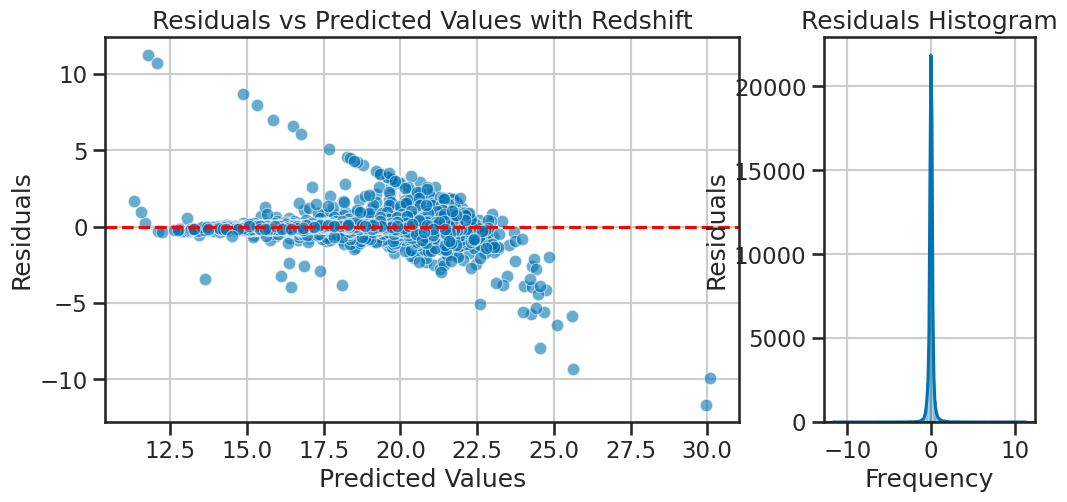

In [9]:
def plot_residuals_with_hist(y_true, y_pred, title="Residuals vs Predicted Values", filename=None, axis=None):

    residuals = y_true - y_pred

    if axis is not None and not (isinstance(axis, (list, tuple)) and len(axis) == 2):
        raise ValueError("axis must be a list or tuple of two matplotlib axes (for scatter and histogram).")

    if axis is None:
        fig, axis = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [3, 1]})

    # Scatter plot: residuals vs predicted
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=axis[0])
    axis[0].axhline(0, color='red', linestyle='--')
    axis[0].set_xlabel('Predicted Values')
    axis[0].set_ylabel('Residuals')
    axis[0].set_title(title)
    axis[0].grid(True)

    # Horizontal histogram: residuals on y, count on x
    sns.histplot(residuals, bins=50, kde=True, ax=axis[1])
    axis[1].axhline(0, color='red', linestyle='--')
    axis[1].set_ylabel('Residuals')
    axis[1].set_xlabel('Frequency')
    axis[1].set_title('Residuals Histogram')
    axis[1].grid(True)

    if filename and axis is None:
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
    if axis is None:
        plt.tight_layout()
        plt.show()

plot_residuals_with_hist(y_test, y_pred, title='Residuals vs Predicted Values with Redshift')

##### Comparing predicted and actual values

We can also plot the predicted values against the actual values; this is the benefit of using supervised learning. We can evaluate how well the model is performing by comparing its predictions to the known actual values. In this plot, if the model is performing well, we would expect the points to be close to the diagonal line (i.e., the line where predicted values equal actual values). 

Based on where the data lie in this plot, we can also tell if the model is over- or under-predicting the target variable.

Importantly, we need to know how much of our data is in this plot at different locations. So we will show how to use a `jointplot` to visualize the distribution of the data points in this plot. This will help us understand how many data points are truly outliers. First, we will plot the predicted values against the actual values, and then we will use a `jointplot` to visualize the distribution of the data points in this plot.

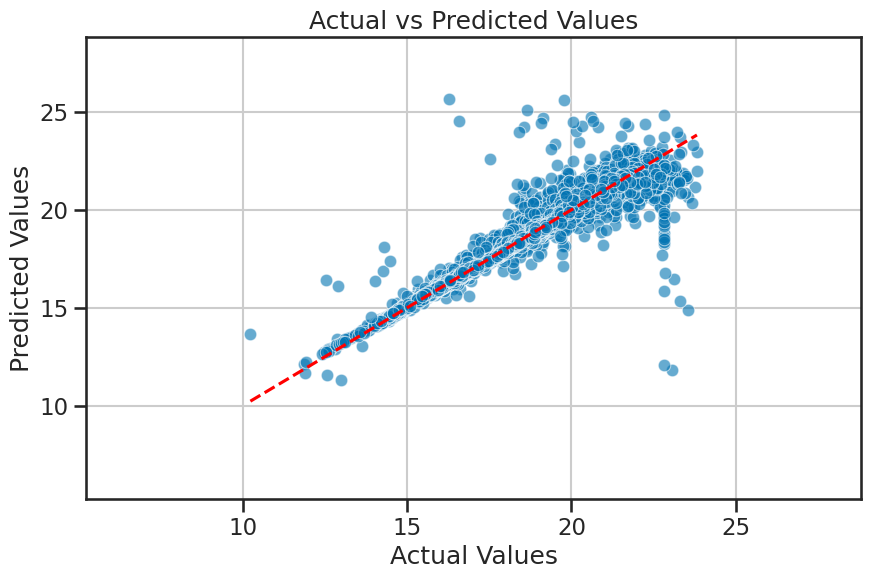

In [10]:
def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted Values', filename=None,axis=None, delta=5):
    if axis is None:
        fig,axis = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, ax=axis)
    axis.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    axis.set_xlim(y_true.min()-delta, y_true.max()+delta)
    axis.set_ylim(y_true.min()-delta, y_true.max()+delta)
    axis.set_xlabel('Actual Values')
    axis.set_ylabel('Predicted Values')
    axis.set_title(title)
    axis.grid(True)
    
    if filename and axis is None:
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
    if axis is None:
        plt.tight_layout()
        plt.show()

# Plot actual vs predicted values
plot_actual_vs_predicted(y_test, y_pred, filename='figures/stellar_regression_results.png')

A `jointplot` is a nice way to visualize the distribution of two variables in a scatter plot. It is a `seaborn` function and it creates a scatter plot with histograms on the axes. We can use it to determine where the majority of the data points lie in the plot, and what really seem to be outliers.

<Figure size 1000x600 with 0 Axes>

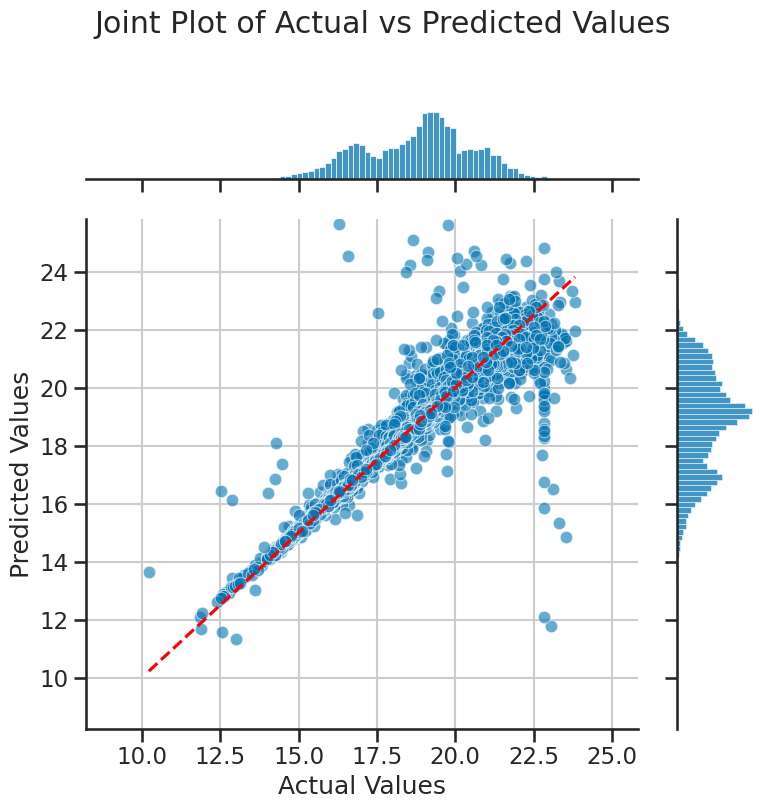

In [11]:
def plot_joint_actual_vs_predicted(y_true, y_pred, filename=None, delta=2):
    plt.figure(figsize=(10, 6))
    sns.jointplot(x=y_true, y=y_pred, kind='scatter', alpha=0.6, height=8)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.xlim(y_true.min()-delta, y_true.max()+delta)
    plt.ylim(y_true.min()-delta, y_true.max()+delta)
    plt.suptitle('Joint Plot of Actual vs Predicted Values', y=1.02)
    plt.grid(True)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

plot_joint_actual_vs_predicted(y_test, y_pred, filename='figures/stellar_joint_plot.png')

#### Unpacking the model

What was the mathmatical model that we fitted? We can unpack that model to see the coefficients for each feature. This will help us understand how much each feature contributes to the prediction of the target variable. We can use the `coef_` attribute of the `LinearRegression` class to get the coefficients of the model. Each model coefficient represents the change in the target variable for a one-unit change in the feature, holding all other features constant. The order of the coefficients corresponds to the order of the features in the dataset, which we can check using the `columns` attribute of the `pandas` DataFrame.

In [12]:
intercept = model.intercept_ #beta0
coefficients = model.coef_ #beta1, beta2, beta3, beta4
features = X.columns.tolist() # feature names

print(intercept)
print(coefficients)
print(features)

18.769633356579455
[ 0.01160737 -0.43194222  0.2577279   1.82800805]
['u', 'g', 'r', 'i']


So given the mathematical model we fitted, we can write the equation for the model as:
$$ z = \beta_0 + \beta_1 u + \beta_2 g + \beta_3 r + \beta_4 i + \epsilon $$
and each coefficient $\beta_i$ corresponds to the feature $i$ in the dataset including the intercept $\beta_0$. 

We can also plot the coefficients to visualize the significance of each feature in the model. As we standardized the features, we can interpret the coefficients as the change in the z-band magnitude for a one standard deviation change in the feature. This means that we can compare the coefficients directly to see which feature has the most significant impact on the z-band magnitude.

**Which feature has the most significant impact on the z-band magnitude?**

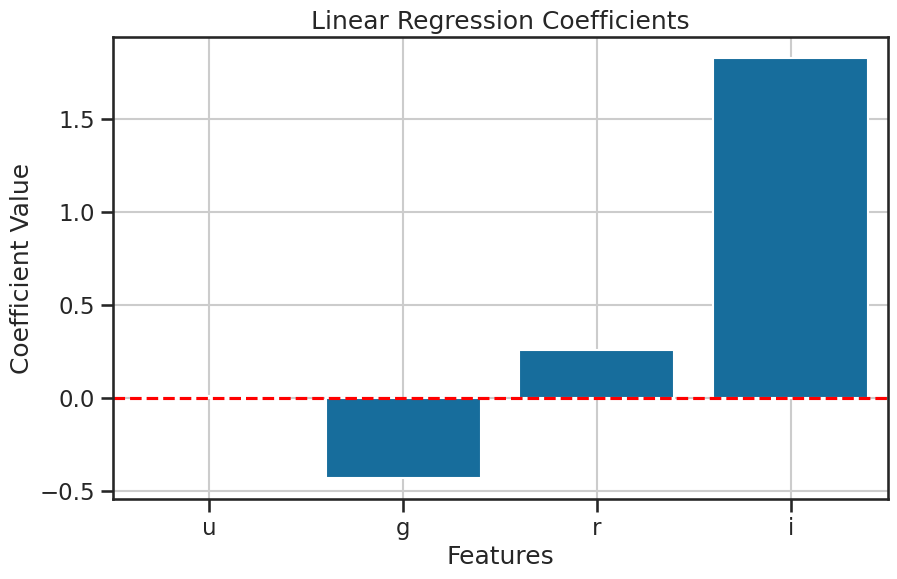

In [13]:
def plot_coefficients(model, feature_names, title='Model Coefficients', filename=None, axis=None):
    coefficients = model.coef_
    if axis is None:
        fig, axis = plt.subplots(figsize=(10, 6))
    sns.barplot(x=feature_names, y=coefficients, ax=axis)
    axis.set_xlabel('Features')
    axis.set_ylabel('Coefficient Value')
    axis.set_title(title)
    axis.axhline(0, color='red', linestyle='--')
    axis.grid(True)
    if filename and axis is None:
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
    if axis is None:
        plt.tight_layout()
        plt.show()
    
plot_coefficients(model, X.columns, title='Linear Regression Coefficients', filename='figures/stellar_regression_coefficients.png')

#### How important is each feature?

The coefficients are a useful way to understand the importance of each feature to the model. But the idea of importance has to be defined for the model. In our case, we are hoping that our model not only predicts accurately, but that is also accounts for the variance in the target variable.

We can first use `score` to get the R-squared score of the model, which tells us how much variance in the target variable is explained by the model. This is a good first step to understand how well the model is performing.

More importantly, we can look at each feature's contribution to the variance explained by the model by first sorting the coefficients by their absolute value. This will give us an idea of which features are most important to the model. We can then build a series of models that add one feature at a time and compute the R-squared score for each model. This will give us an idea of how much each feature contributes to the variance explained by the model.

In [14]:
evaluate_regression(y_test, y_pred, label="Linear Regression (u, g, r, i)")

Results for Linear Regression (u, g, r, i):
  Mean Squared Error: 0.1645
  R-squared: 0.9470


(0.16451171809284237, 0.9470343482118453)

In [15]:
coefficients = model.coef_ #beta1, beta2, beta3, beta4
features = X.columns.tolist() # feature names

# sort features by their coefficients in descending order
sorted_indices = np.argsort(np.abs(coefficients))[::-1] 

# sort features
sorted_features = [features[i] for i in sorted_indices]

# print sorted features
print(sorted_features)

['i', 'g', 'r', 'u']


That little piece of code is very useful for later, so let's quickly write it up as a function.

In [16]:
def get_sorted_features_by_coef(model, X):
    """
    Returns feature names sorted by the absolute value of their coefficients (descending).
    """
    coefficients = model.coef_
    features = X.columns.tolist()
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]
    sorted_features = [features[i] for i in sorted_indices]
    print(sorted_features)
    return sorted_features

sorted_features = get_sorted_features_by_coef(model, X)

['i', 'g', 'r', 'u']


And now, we can plot the explained variance for each feature. This will help us understand how much each feature contributes to the model's performance. We can use a plot to show how $R^2$ changes as we add more features to the model.

#### ✅ Tasks:
1. Run the code below to unpack the model and visualize the coefficients.
2. Make sure you understand what each line of code does.
3. Discuss the results with your group.

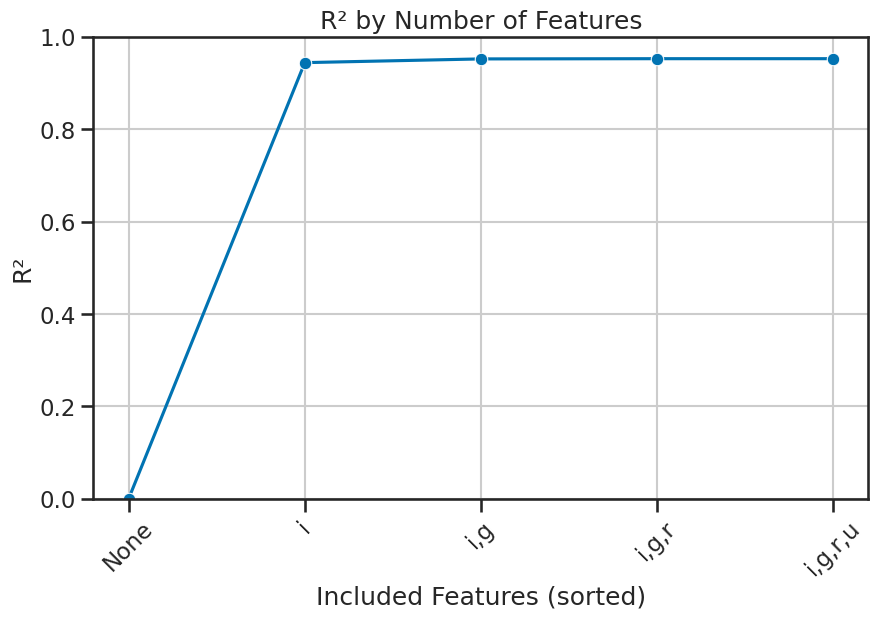

In [17]:
def plot_explained_variance(model, X, y, sorted_features, title='Explained Variance by Number of Features', filename=None, axis=None):
    explained_variance = [0]  # Start with 0 for no variables
    feature_labels = ['None']
    for i in range(1, len(sorted_features) + 1):
        selected = sorted_features[:i]
        model.fit(X[selected], y)
        explained_variance.append(model.score(X[selected], y))
        feature_labels.append(','.join(selected))
    
    if axis is None:
        fig, axis = plt.subplots(figsize=(10, 6))
    sns.lineplot(x=range(len(feature_labels)), y=explained_variance, marker='o', ax=axis)
    axis.set_xticks(range(len(feature_labels)))
    axis.set_xticklabels(feature_labels, rotation=45)
    axis.set_xlabel('Included Features (sorted)')
    axis.set_ylabel('R²')
    axis.set_title(title)
    axis.set_ylim(0, 1)
    axis.grid(True)
    if filename and axis is None:
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
    if axis is None:
        plt.tight_layout()
        plt.show()

# Plot the explained variance ratio using sorted_features
plot_explained_variance(model, X, y, sorted_features, title='R² by Number of Features', filename='figures/stellar_explained_variance_sorted.png')

---
<a id="modeling-z-band-magnitude-redshift"></a>
## 3. Modeling the z-band magnitude with redshift

Great, now we have a good understanding of how to perform regression analysis with `scikit-learn`. We will now extend our model to include the `redshift` feature. This will allow us to see how well the model performs when we include this additional feature.

#### ✅ Tasks:
1. Using the code that you reviewed above, modify the code to include the `redshift` feature in the regression model.
2. Include all the visualizations you created above to evaluate the model.
3. Compare the results of this model to the previous model without redshift and with models made by others.


Results for Linear Regression (u, g, r, i, redshift):
  Mean Squared Error: 0.1641
  R-squared: 0.9472
['i', 'g', 'r', 'redshift', 'u']


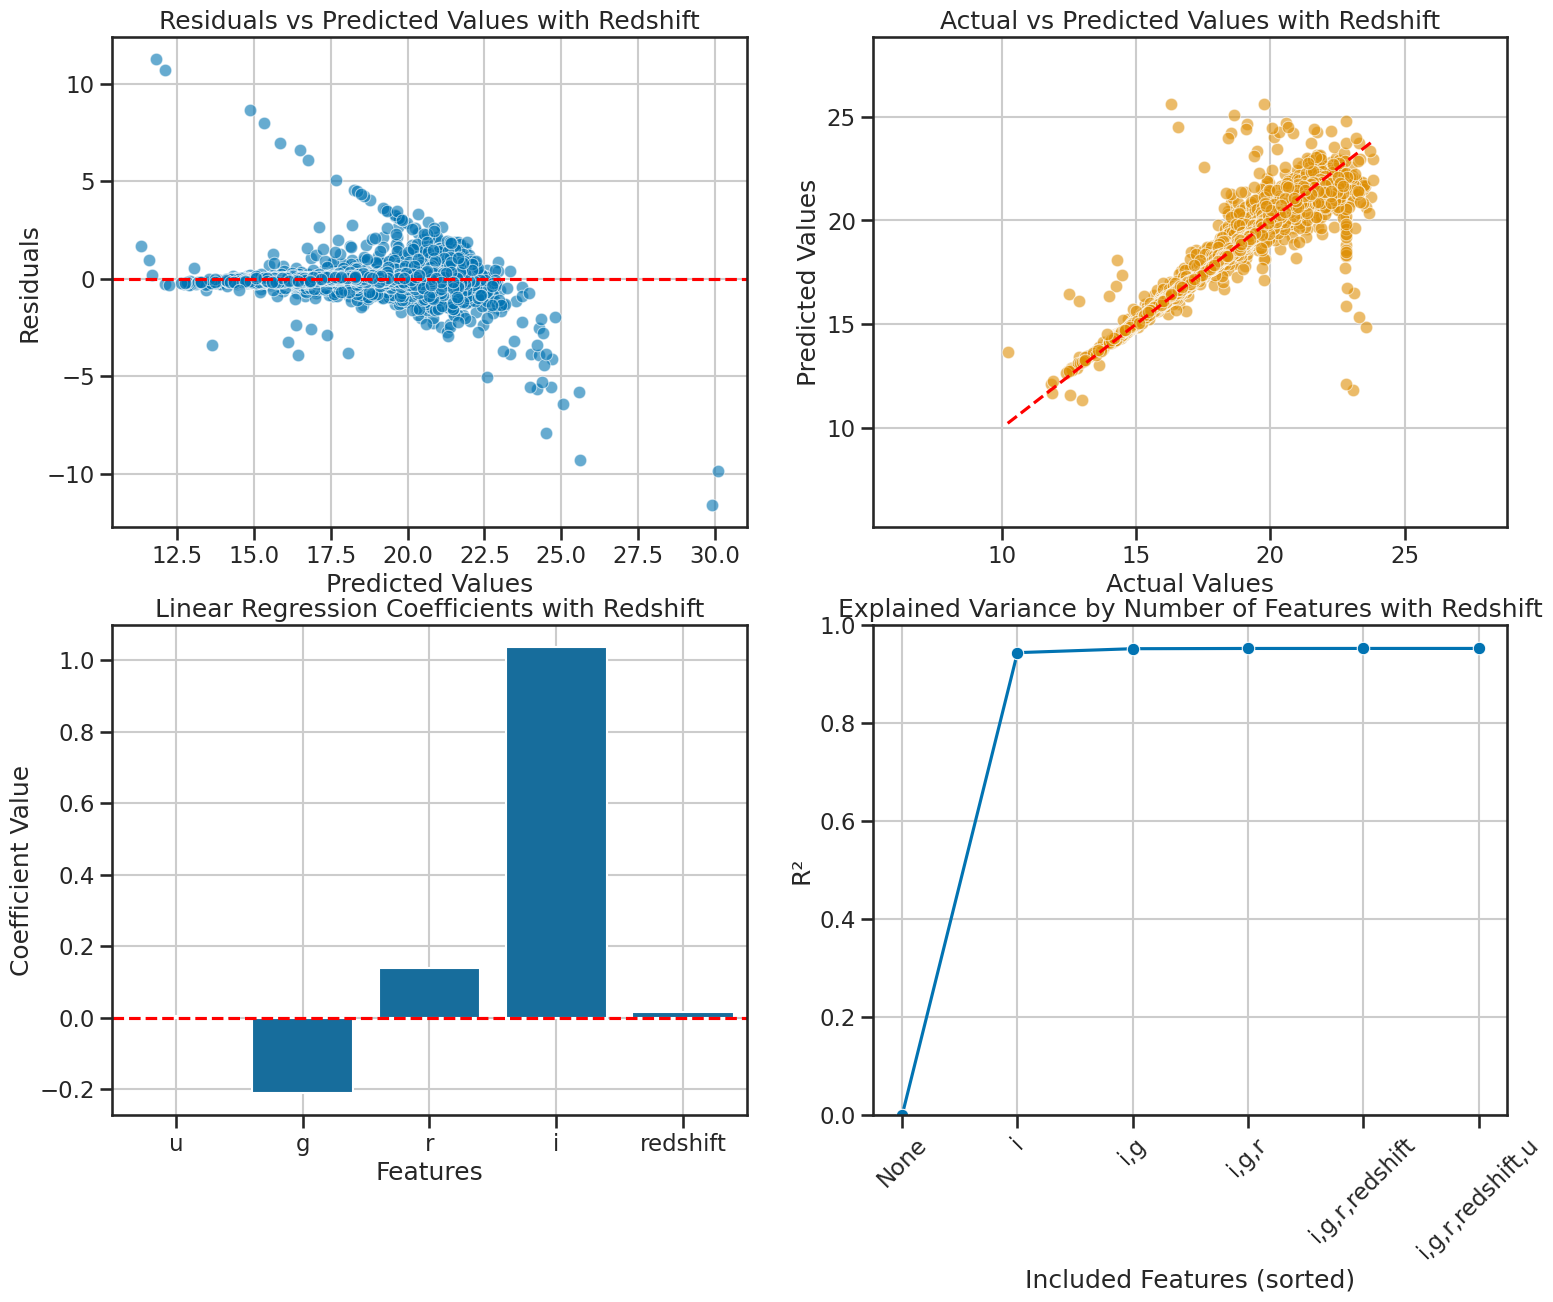

In [18]:
### your code here

# Add redshift to the features and see if it improves the model.
X = df_stellar[['u', 'g', 'r', 'i', 'redshift']]

# Split the data into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit a new linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the new model using the custom function
evaluate_regression(y_test, y_pred, label="Linear Regression (u, g, r, i, redshift)")

# Sort the features by their coefficients in descending order again
sorted_features = get_sorted_features_by_coef(model, X)

fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_residuals_with_hist(y_test, y_pred, title='Residuals vs Predicted Values with Redshift', axis=[axs[0, 0], axs[0, 1]])
plot_actual_vs_predicted(y_test, y_pred, title='Actual vs Predicted Values with Redshift', axis=axs[0, 1])
plot_coefficients(model, X.columns, title='Linear Regression Coefficients with Redshift', axis=axs[1, 0])
plot_explained_variance(model, X, y, sorted_features, title='Explained Variance by Number of Features with Redshift', axis=axs[1, 1])

---
<a id="modeling-z-band-magnitude-class-redshift"></a>
## 4. Modeling each class separately with redshift

Now, that we see how we can model the whole dataset, and we can see what features are important to the model, we can now model each class separately. This will allow us to see how well the model performs for each class and how the features contribute to the prediction of the z-band magnitude for each class. It might be different for each class, and that might ultimately improve our model and our understanding of the data.

#### ✅ Tasks:
1. Using the code that you reviewed above, modify the code to model each class separately with redshift.
2. Include all the visualizations you created above to evaluate the model.
3. Compare the results of this model to the previous models and to the models made by others.

Results for Linear Regression for class GALAXY:
  Mean Squared Error: 0.1253
  R-squared: 0.9543
['i', 'redshift', 'r', 'g', 'u']


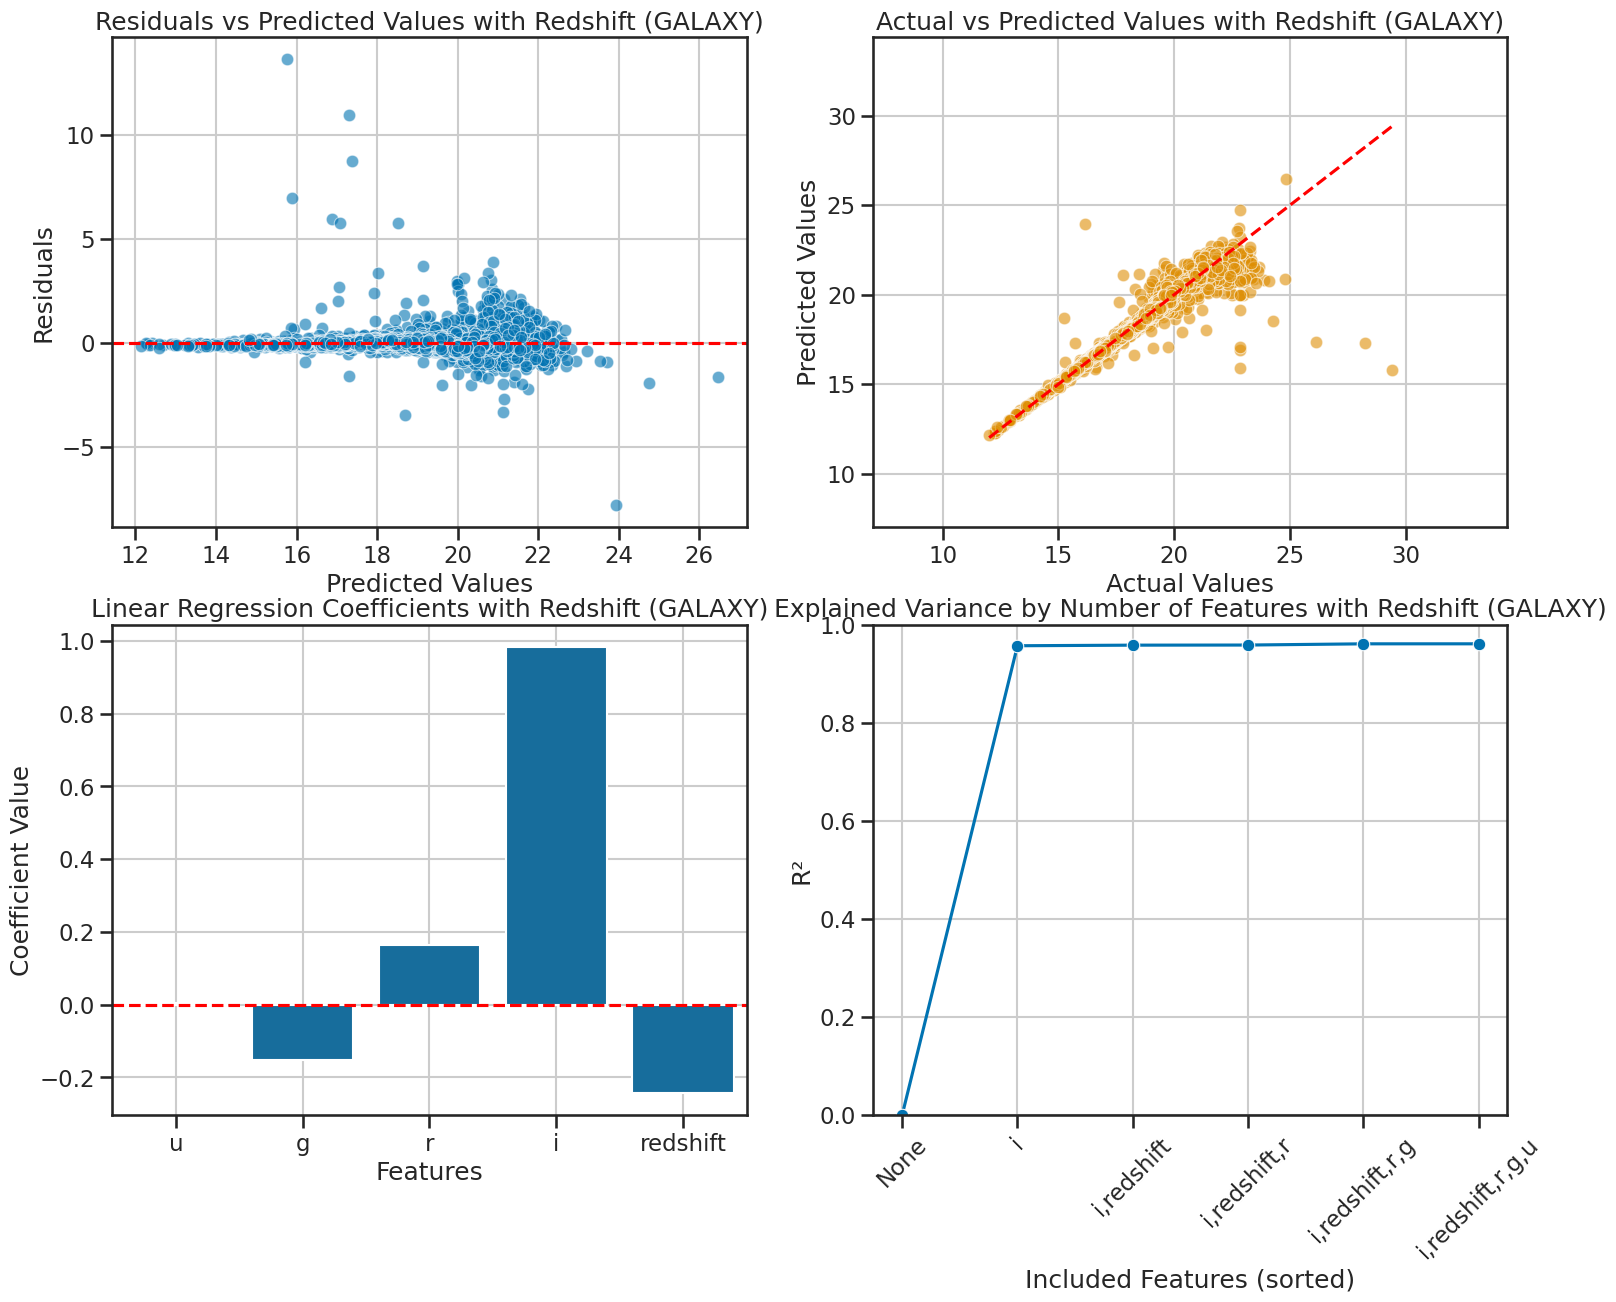

In [19]:
### your code here

# GALAXY
df_galaxy = df_stellar[df_stellar['class'] == 'GALAXY']

X_galaxy = df_galaxy.drop(columns=['obj_ID', 'z', 'class'])
y_galaxy = df_galaxy['z']

X_train_galaxy, X_test_galaxy, y_train_galaxy, y_test_galaxy = train_test_split(X_galaxy, y_galaxy, test_size=0.2, random_state=42)

model_galaxy = LinearRegression()
model_galaxy.fit(X_train_galaxy, y_train_galaxy)

y_pred_galaxy = model_galaxy.predict(X_test_galaxy)

evaluate_regression(y_test_galaxy, y_pred_galaxy, label="Linear Regression for class GALAXY")

sorted_features_galaxy = get_sorted_features_by_coef(model_galaxy, X_galaxy)

fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_residuals_with_hist(y_test_galaxy, y_pred_galaxy, title='Residuals vs Predicted Values with Redshift (GALAXY)', axis=[axs[0, 0], axs[0, 1]])
plot_actual_vs_predicted(y_test_galaxy, y_pred_galaxy, title='Actual vs Predicted Values with Redshift (GALAXY)', axis=axs[0, 1])
plot_coefficients(model_galaxy, X_galaxy.columns, title='Linear Regression Coefficients with Redshift (GALAXY)', axis=axs[1, 0])
plot_explained_variance(model_galaxy, X_galaxy, y_galaxy, sorted_features_galaxy, title='Explained Variance by Number of Features with Redshift (GALAXY)', axis=axs[1, 1])

Results for Linear Regression for class QSO:
  Mean Squared Error: 0.1550
  R-squared: 0.8668
['i', 'r', 'g', 'redshift', 'u']


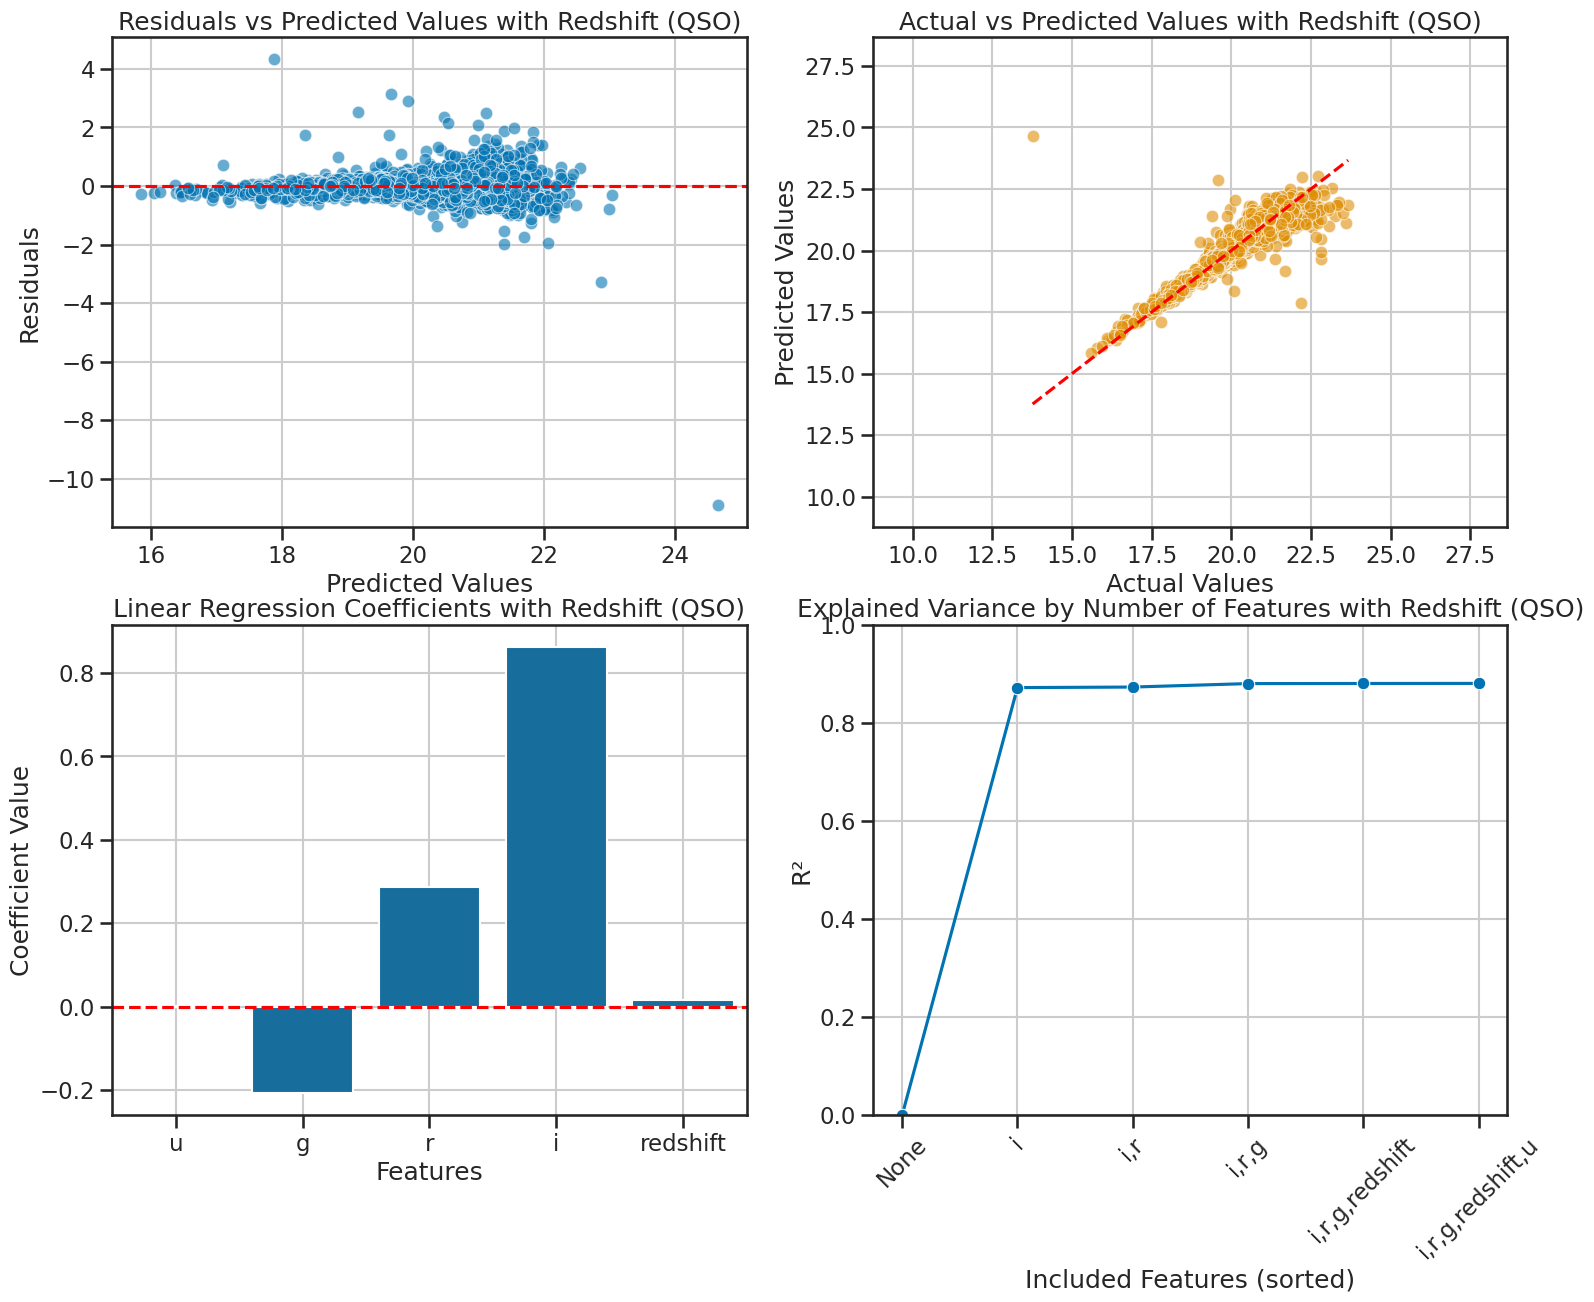

In [20]:
### your code here

# QSO
df_qso = df_stellar[df_stellar['class'] == 'QSO']

X_qso = df_qso.drop(columns=['obj_ID', 'z', 'class'])
y_qso = df_qso['z']

X_train_qso, X_test_qso, y_train_qso, y_test_qso = train_test_split(X_qso, y_qso, test_size=0.2, random_state=42)

model_qso = LinearRegression()
model_qso.fit(X_train_qso, y_train_qso)

y_pred_qso = model_qso.predict(X_test_qso)

evaluate_regression(y_test_qso, y_pred_qso, label="Linear Regression for class QSO")

sorted_features_qso = get_sorted_features_by_coef(model_qso, X_qso)

fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_residuals_with_hist(y_test_qso, y_pred_qso, title='Residuals vs Predicted Values with Redshift (QSO)', axis=[axs[0, 0], axs[0, 1]])
plot_actual_vs_predicted(y_test_qso, y_pred_qso, title='Actual vs Predicted Values with Redshift (QSO)', axis=axs[0, 1])
plot_coefficients(model_qso, X_qso.columns, title='Linear Regression Coefficients with Redshift (QSO)', axis=axs[1, 0])
plot_explained_variance(model_qso, X_qso, y_qso, sorted_features_qso, title='Explained Variance by Number of Features with Redshift (QSO)', axis=axs[1, 1])

Results for Linear Regression for class STAR:
  Mean Squared Error: 0.2491
  R-squared: 0.9270
['redshift', 'i', 'g', 'r', 'u']


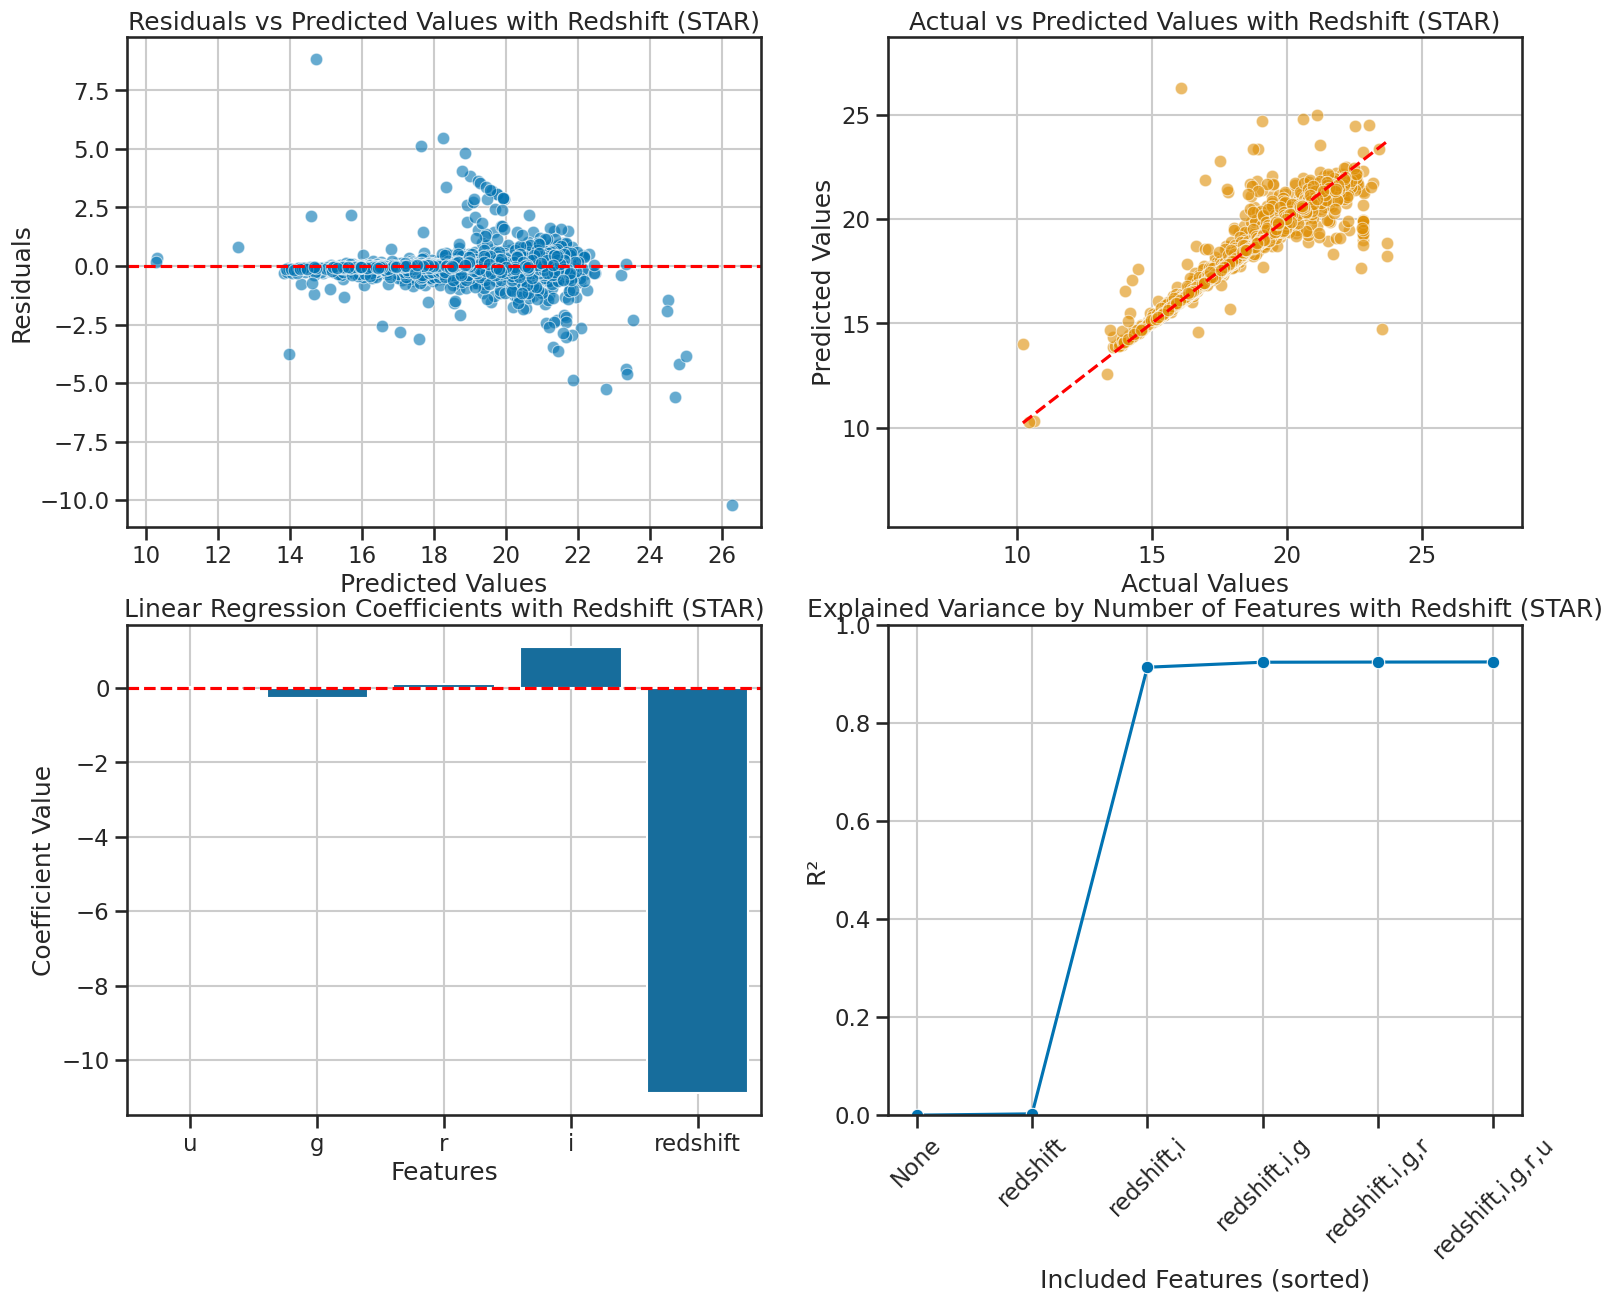

In [21]:
### your code here

# STAR
df_star = df_stellar[df_stellar['class'] == 'STAR']

X_star = df_star.drop(columns=['obj_ID', 'z', 'class'])
y_star = df_star['z']

X_train_star, X_test_star, y_train_star, y_test_star = train_test_split(X_star, y_star, test_size=0.2, random_state=42)

model_star = LinearRegression()
model_star.fit(X_train_star, y_train_star)

y_pred_star = model_star.predict(X_test_star)

evaluate_regression(y_test_star, y_pred_star, label="Linear Regression for class STAR")

sorted_features_star = get_sorted_features_by_coef(model_star, X_star)

fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_residuals_with_hist(y_test_star, y_pred_star, title='Residuals vs Predicted Values with Redshift (STAR)', axis=[axs[0, 0], axs[0, 1]])
plot_actual_vs_predicted(y_test_star, y_pred_star, title='Actual vs Predicted Values with Redshift (STAR)', axis=axs[0, 1])
plot_coefficients(model_star, X_star.columns, title='Linear Regression Coefficients with Redshift (STAR)', axis=axs[1, 0])
plot_explained_variance(model_star, X_star, y_star, sorted_features_star, title='Explained Variance by Number of Features with Redshift (STAR)', axis=axs[1, 1])

---
<a id="#using-other-regression-models-e-g-randomforestregressor"></a>
## 5. Using other regression models (e.g., `RandomForestRegressor`)

The great thing about `scikit-learn` is that it provides a wide range of regression models that we can use to improve our predictions. We can try different models and see how they perform compared to the linear regression model we used above.

#### ✅ Tasks:
1. Research and implement a different regression model from `scikit-learn`, such as `RandomForestRegressor`, `GradientBoostingRegressor`, or any other regression model you find interesting.
2. Compare the results of this model to the previous models and to the models made by others.
3. Discuss the differences in performance and interpretability of the different models with your group.

**You are free to choose the subset of data to use for this task.You are welcome to change the features and the target variable to see how the model performs with different data.**


In [22]:
### your code here

# Let's try using a more complex model, like a Random Forest Regressor, to see if it improves the predictions.
# Let's focus on the STAR only because it has the highest MSE.

# Extract the STAR class data
df_star = df_stellar[df_stellar['class'] == 'STAR']

# Define the features and target variable
X_star = df_star.drop(columns=['obj_ID', 'z', 'class'])
y_star = df_star['z']
cols = X_star.columns

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler_star = StandardScaler()
scaler_star.fit(X_star)
X_star = scaler_star.transform(X_star)

# Split the data into training and testing sets
X_train_star, X_test_star, y_train_star, y_test_star = train_test_split(X_star, y_star, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
# Create and fit a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)
rf_model.fit(X_train_star, y_train_star)

# Make predictions on the test set
y_pred_star = rf_model.predict(X_test_star)

# Evaluate the Random Forest model
evaluate_regression(y_test_star, y_pred_star, label="Random Forest Regressor for STAR class")

# Sort the features by their importance
sorted_indices_star = np.argsort(rf_model.feature_importances_)[::-1]
# Get the sorted feature names
sorted_features_star = [cols[i] for i in sorted_indices_star]

Results for Random Forest Regressor for STAR class:
  Mean Squared Error: 0.1647
  R-squared: 0.9517


In [23]:
### your code here

# I had to update plot_coefficients to handle both linear models and tree-based models like Random Forest. Here's the updated function:

def plot_coefficients(model, feature_names, title='Model Coefficients', filename=None, axis=None):
    # Use coef_ for linear models, feature_importances_ for tree-based models
    if hasattr(model, "coef_"):
        coefficients = model.coef_
        ylabel = 'Coefficient Value'
    elif hasattr(model, "feature_importances_"):
        coefficients = model.feature_importances_
        ylabel = 'Feature Importance'
    else:
        raise AttributeError("Model does not have coef_ or feature_importances_ attribute.")
    if axis is None:
        fig, axis = plt.subplots(figsize=(10, 6))
    sns.barplot(x=feature_names, y=coefficients, ax=axis)
    axis.set_xlabel('Features')
    axis.set_ylabel(ylabel)
    axis.set_title(title)
    axis.axishline(0, color='red', linestyle='--') if hasattr(model, "coef_") else None
    if filename and axis is None:
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
    if axis is None:
        plt.tight_layout()
        plt.show()

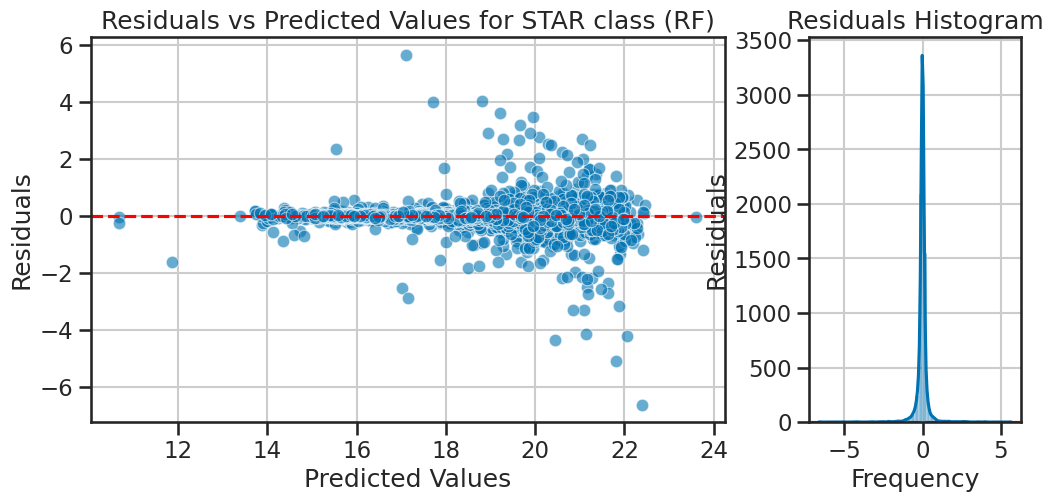

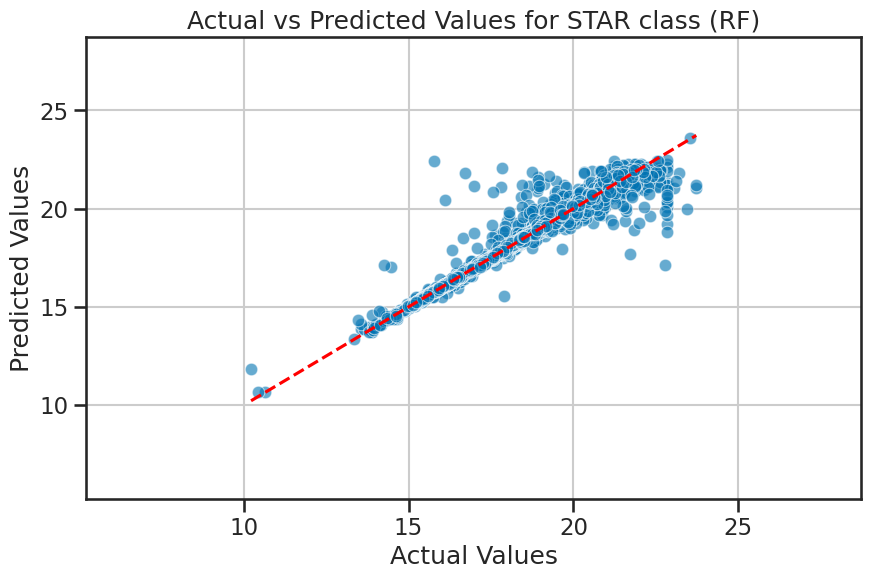

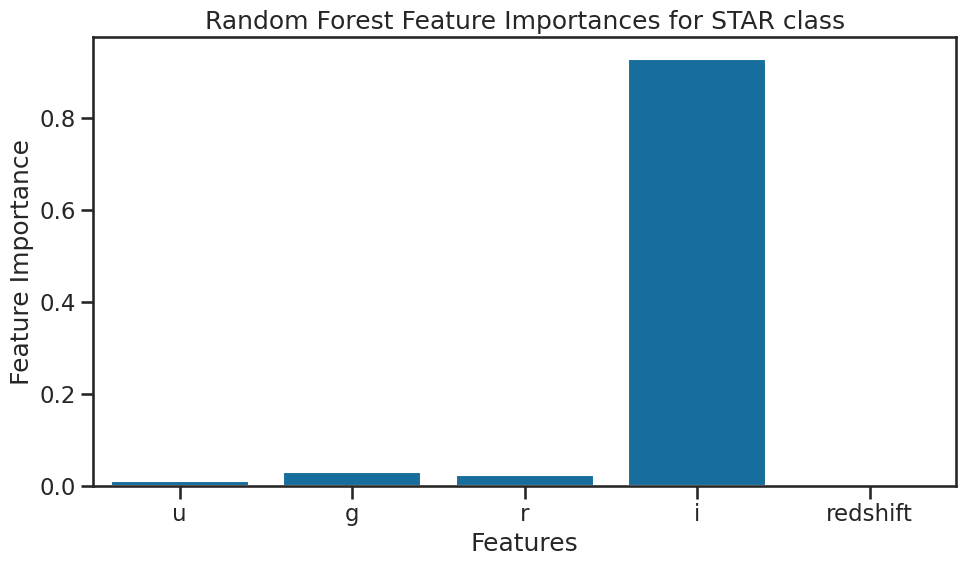

In [24]:
### your code here

plot_residuals_with_hist(y_test_star, y_pred_star, title='Residuals vs Predicted Values for STAR class (RF)')
plot_actual_vs_predicted(y_test_star, y_pred_star, title='Actual vs Predicted Values for STAR class (RF)')
plot_coefficients(rf_model, cols, title='Random Forest Feature Importances for STAR class')
plt.tight_layout()
plt.savefig('figures/stellar_rf_regression_star_subplots.png', dpi=300)
plt.show()